# Analyze MTurk Classification Task Data

This notebook produces Figure 8.

In [1]:
import json
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy import ndarray as Array
import pandas as pd

#------------------------------------------------------------------------------
# Define global settings.

ACTIONS = ["clench", "pinch", "palm", "poke"]
CHANCE_LEVEL = 1 / len(ACTIONS)
data_dir = '/Users/sharon/data/EE148/affordance/mturk_classification_results'
image_dir = '/Users/sharon/data/EE148/affordance/segmentation_amazon_mturk_combined'
output_dir = 'images/analysis-results'

## 1. Load MTurk Data from All Runs

In [2]:
def load_data(directory):
    """Load the original image names from a directory, and make combined images."""

    print(directory)
    result = {}
    for root, _, fnames in sorted(os.walk(directory)):
        for fname in fnames:
            path = os.path.join(root, fname)
            with open(path) as f:
                data = json.load(f)
                for d in data:
                    result[d['datasetObjectId']] = d
    return result

def load_mturk_data():
    data = {}
    num_runs = 4
    for i in range(num_runs):
        data[i] = load_data('%s/schen5-labeling03-mturk-%d' % (data_dir, i))
        data[i] = [d[1] for d in sorted(data[i].items(), key=lambda x: int(x[0]))]
    return data

In [3]:
data = load_mturk_data() # run x image

/Users/sharon/data/EE148/affordance/mturk_classification_results/schen5-labeling03-mturk-0
/Users/sharon/data/EE148/affordance/mturk_classification_results/schen5-labeling03-mturk-1
/Users/sharon/data/EE148/affordance/mturk_classification_results/schen5-labeling03-mturk-2
/Users/sharon/data/EE148/affordance/mturk_classification_results/schen5-labeling03-mturk-3


In [4]:
len(data[3])

68

## 2. Group Data by Image across All Runs

In [5]:
def combine_runs(data):
    combined_data = data[0] # initialize with data from first run
    for i in range(1, len(data)): # add annotations from other runs, run index i
        for j in range(len(data[i])): # image index j
            d = data[i][j]
            combined_data[j]['annotations'].extend(d['annotations'])
    return combined_data

In [6]:
data = combine_runs(data)

In [7]:
data

[{'datasetObjectId': '0',
  'dataObject': {'s3Uri': 's3://schen5-bucket05/segmentation_amazon_mturk_combined/31-aBsPwUYL._AC__pinch_combined.png'},
  'annotations': [{'workerId': 'public.us-east-1.A2KHLJ2F58BEZK',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.APXNY64HXO08K',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.AG36U7IOG2LAP',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"poke"}}'}},
   {'workerId': 'public.us-east-1.ADCO9J1CKN0P9',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.A3VBUVGBQ74JJF',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.A59CK9XXJ6RMP',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"pinch"}}'}},
   {'workerId': 'public.us-e

## 3. Get MTurk Worker Information

In [8]:
def get_workers(data):
    """Get the workers and their performance on the catch tasks."""

    workers = {}
    correct_cnt, incorrect_cnt = 0, 0
    for j in range(len(data)):
        d = data[j]
        if 'catch' in d['dataObject']['s3Uri']:
            true_label = d['dataObject']['s3Uri'].split('catch-')[1].split('.')[0]
            for annotation in d['annotations']:
                worker_id = annotation['workerId']
                if worker_id not in workers:
                    workers[worker_id] = {'correct': 0, 'incorrect': 0}
                worker_label = json.loads(annotation['annotationData']['content'])\
                    ['crowd-image-classifier']['label']
                if true_label == worker_label:
                    workers[worker_id]['correct'] += 1
                    correct_cnt += 1
                else:
                    workers[worker_id]['incorrect'] += 1
                    incorrect_cnt += 1
    return workers, correct_cnt, incorrect_cnt

In [9]:
workers, correct_cnt, incorrect_cnt = get_workers(data)

In [10]:
len(workers)

61

In [11]:
print(correct_cnt, incorrect_cnt)

74 34


In [12]:
workers

{'public.us-east-1.APXNY64HXO08K': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A3VBUVGBQ74JJF': {'correct': 0, 'incorrect': 3},
 'public.us-east-1.A59CK9XXJ6RMP': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A2H90QIP05I3LU': {'correct': 5, 'incorrect': 0},
 'public.us-east-1.AEYZI1SFFJ172': {'correct': 0, 'incorrect': 1},
 'public.us-east-1.A1EYA0FKRN0ZG1': {'correct': 0, 'incorrect': 1},
 'public.us-east-1.A2KI119C3LYEFY': {'correct': 4, 'incorrect': 1},
 'public.us-east-1.A31A1PVXLJBISZ': {'correct': 0, 'incorrect': 1},
 'public.us-east-1.ASD8FSVVY8ZBF': {'correct': 0, 'incorrect': 1},
 'public.us-east-1.A2A1E54KP5OOWJ': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A1DRKZ3SCLAS4V': {'correct': 3, 'incorrect': 3},
 'public.us-east-1.ALCPF5NANBDSZ': {'correct': 2, 'incorrect': 0},
 'public.us-east-1.A2YBRWIUM45CAJ': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A2Q8KGUMORTU8L': {'correct': 2, 'incorrect': 1},
 'public.us-east-1.A277Y2HW4L10CR': {'correct': 4, 'i

## 4. Filter Out Data from Low-Quality MTurk Workers

In [13]:
def get_good_data(data):
    """Get only the annotations from the good workers."""
    good_workers = {w: workers[w] for w in workers if workers[w]['correct'] > 0 and workers[w]['incorrect'] == 0}
    good_data = []
    for j in range(len(data)):
        d = data[j]
        d['annotations'] = [annotation for annotation in d['annotations']
                            if annotation['workerId'] in good_workers]
        good_data.append(d)
    return good_workers, good_data

In [14]:
good_workers, good_data = get_good_data(data)

In [15]:
len(good_workers)

36

In [16]:
good_workers

{'public.us-east-1.APXNY64HXO08K': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A59CK9XXJ6RMP': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A2H90QIP05I3LU': {'correct': 5, 'incorrect': 0},
 'public.us-east-1.A2A1E54KP5OOWJ': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.ALCPF5NANBDSZ': {'correct': 2, 'incorrect': 0},
 'public.us-east-1.A2YBRWIUM45CAJ': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A277Y2HW4L10CR': {'correct': 4, 'incorrect': 0},
 'public.us-east-1.A3EP5HTL8IEJTA': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A3UJX60MALFMW0': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A1QKW8E5J7NAF2': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A2HJDS8EWQTYFY': {'correct': 3, 'incorrect': 0},
 'public.us-east-1.ARNLA2XM2CXR4': {'correct': 3, 'incorrect': 0},
 'public.us-east-1.A1F7TXGSWETWX0': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A1FGEOPFNUXCHQ': {'correct': 1, 'incorrect': 0},
 'public.us-east-1.A2XD5QTL6H2LIY': {'correct': 1, '

In [17]:
good_data

[{'datasetObjectId': '0',
  'dataObject': {'s3Uri': 's3://schen5-bucket05/segmentation_amazon_mturk_combined/31-aBsPwUYL._AC__pinch_combined.png'},
  'annotations': [{'workerId': 'public.us-east-1.APXNY64HXO08K',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.A59CK9XXJ6RMP',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"pinch"}}'}},
   {'workerId': 'public.us-east-1.A2H90QIP05I3LU',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.A2H90QIP05I3LU',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"poke"}}'}},
   {'workerId': 'public.us-east-1.ALCPF5NANBDSZ',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"palm"}}'}},
   {'workerId': 'public.us-east-1.A2YBRWIUM45CAJ',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"poke"}}'}},
   {'workerId': 'public.us-east

## 5. Analyze the Data

In [18]:
def get_stats(data):
    """Get how many labels from the mturk workers match or not match the true labels."""

    stats = []
    match = 0 # The total number of worker labels == predicted labels
    nonmatch = 0 # The total number of worker labels != predicted labels
    accuracies = [] # list of accuracies, where accuracy = match / (nonmatch + match) for each image
    for j in range(len(data)):
        d = data[j]
        if 'catch' not in d['dataObject']['s3Uri']:
            true_label = d['dataObject']['s3Uri'].split('_combined.png')[0].split('_')[-1]
            d['stats'] = {'match': 0, 'nonmatch': 0}
            for annotation in d['annotations']:
                worker_label = json.loads(annotation['annotationData']['content'])\
                    ['crowd-image-classifier']['label']
                if true_label == worker_label:
                    match += 1
                    d['stats']['match'] += 1
                else:
                    nonmatch += 1
                    d['stats']['nonmatch'] += 1
            # if d['stats']['nonmatch'] < d['stats']['match']:
            accuracies.append([j, true_label, d['dataObject']['s3Uri'].split('/')[-1], 
                               d['stats']['match'] / len(d['annotations']), len(d['annotations'])])
            stats.append(d)
    accuracies = pd.DataFrame(accuracies, columns=['image_idx', 'true_label', 'image_name', 'y', 'n'])
    return stats, match, nonmatch, accuracies

# For each image, plot the worker labels bar graph and mark the predicted label

In [19]:
stats, match, nonmatch, acc_df = get_stats(good_data)

In [20]:
len(stats)

65

In [21]:
y = acc_df[['y']]

In [22]:
stats

[{'datasetObjectId': '0',
  'dataObject': {'s3Uri': 's3://schen5-bucket05/segmentation_amazon_mturk_combined/31-aBsPwUYL._AC__pinch_combined.png'},
  'annotations': [{'workerId': 'public.us-east-1.APXNY64HXO08K',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.A59CK9XXJ6RMP',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"pinch"}}'}},
   {'workerId': 'public.us-east-1.A2H90QIP05I3LU',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"clench"}}'}},
   {'workerId': 'public.us-east-1.A2H90QIP05I3LU',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"poke"}}'}},
   {'workerId': 'public.us-east-1.ALCPF5NANBDSZ',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"palm"}}'}},
   {'workerId': 'public.us-east-1.A2YBRWIUM45CAJ',
    'annotationData': {'content': '{"crowd-image-classifier":{"label":"poke"}}'}},
   {'workerId': 'public.us-east

In [23]:
def plot_distribution(y):
    plt.title('Distribution of Accuracies across Images')
    plt.hist(y)
    plt.xlabel('Accuracy')
    plt.ylabel('Number of images')
    plt.show()

def plot_pdf_cdf(y):
    # getting data of the histogram
    count, bins_count = np.histogram(y, bins=10)

    # finding the PDF of the histogram using count values
    pdf = count / sum(count)

    # using numpy np.cumsum to calculate the CDF
    # We can also find using the PDF values by looping and adding
    cdf = np.cumsum(pdf)

    # plotting PDF and CDF
    plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(bins_count[1:], cdf, label="CDF")
    plt.legend()
    plt.title('Distribution of Accuracies across Images')
    plt.xlabel('Accuracy')
    plt.ylabel('Percentile')
    plt.show()

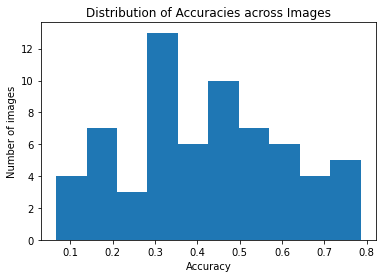

In [24]:
plot_distribution(y)

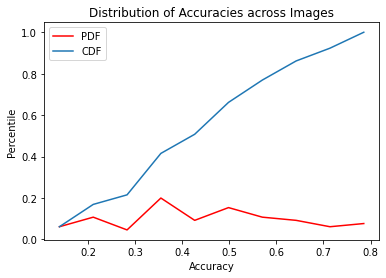

In [25]:
plot_pdf_cdf(y)

### Perform significance test

In [26]:
from scipy.stats import ttest_1samp

def test_significance(y, print_result=False):
    print(len(y))
    stat, p = ttest_1samp(y, CHANCE_LEVEL, alternative='greater')
    if print_result:
        print('H0: mean is %s' % CHANCE_LEVEL)
        print('Observed mean: ', np.mean(y))
        print('Statistics=%.20f, p=%.20f' % (stat, p))
        # interpret
        alpha = 0.05
        if p > alpha:
            print('Same distributions (fail to reject H0)')
        else:
            print('Different distributions (reject H0)')
    return stat, p

In [27]:
test_significance(y, print_result=True)
for action in ACTIONS:
    print('-------')
    print('action: %s' % action)
    test_significance(acc_df.loc[acc_df['true_label'] == action][['y']], print_result=True)

65
H0: mean is 0.25
Observed mean:  y    0.418113
dtype: float64
Statistics=7.42384957212695528739, p=0.00000000016716181277
Different distributions (reject H0)
-------
action: clench
20
H0: mean is 0.25
Observed mean:  y    0.524747
dtype: float64
Statistics=6.96994296054909590055, p=0.00000060898622401828
Different distributions (reject H0)
-------
action: pinch
18
H0: mean is 0.25
Observed mean:  y    0.492973
dtype: float64
Statistics=6.80508303104063649869, p=0.00000153283617967216
Different distributions (reject H0)
-------
action: palm
20
H0: mean is 0.25
Observed mean:  y    0.260366
dtype: float64
Statistics=0.40240288868708862235, p=0.34593939453143685014
Same distributions (fail to reject H0)
-------
action: poke
7
H0: mean is 0.25
Observed mean:  y    0.371651
dtype: float64
Statistics=3.23410754905245800828, p=0.00890913618769872788
Different distributions (reject H0)


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_box_swarm(y, title, name):
    sns.set_style("whitegrid")
    ax = plt.figure(figsize=(5, 5), dpi=100)
    ax = sns.boxplot(data=pd.DataFrame(y), whis=np.inf)
    ax = sns.swarmplot(data=pd.DataFrame(y), color=".2")
    ax.hlines(np.mean(y), -1, 1, color='orange', label='Mean: %.2f' % np.mean(y))
    ax.hlines(CHANCE_LEVEL, -1, 1, color='red', label='Chance: %s' % CHANCE_LEVEL)
    ax.set_ylim(0,1)
    ax.set_yticklabels(['%.01f' % y for y in ax.get_yticks()], size = 13)
    plt.title(title, y=1, fontsize = 14)
    alpha = 0.05
    stat, p = test_significance(y)
    if p <= alpha:
        plt.text(0, y.max() + .05, "***", ha='center', va='bottom', color=".2", fontsize=25, label='p=%.2f' % p)
    plt.tick_params(bottom = False, labelbottom = False)
    plt.ylabel('Accuracy', fontsize = 14)
    sns.set(font_scale = .5)
    plt.legend()
    plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
    plt.savefig('%s/%s' % (output_dir, name))
    plt.show()

65

<ipython-input-28-291aeed06d50>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.01f' % y for y in ax.get_yticks()], size = 13)


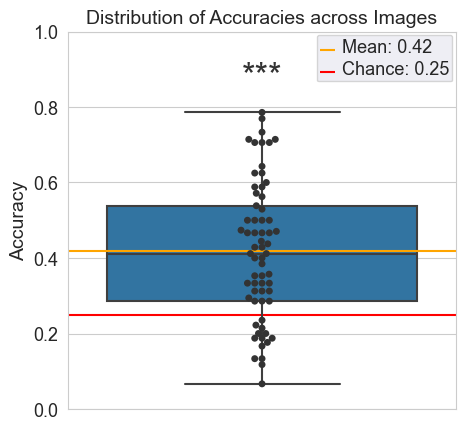

In [29]:
plot_box_swarm(y, 'Distribution of Accuracies across Images',
               'mturk-classification-accuracies-box-swarm-plot.png')

20


<ipython-input-28-291aeed06d50>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.01f' % y for y in ax.get_yticks()], size = 13)


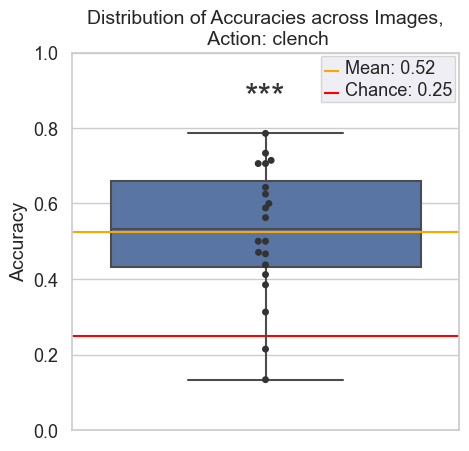

18


<ipython-input-28-291aeed06d50>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.01f' % y for y in ax.get_yticks()], size = 13)


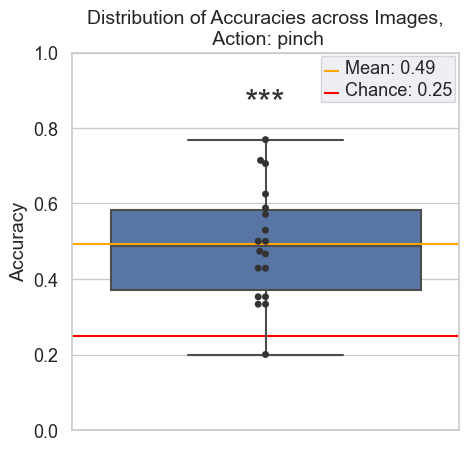

20


<ipython-input-28-291aeed06d50>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.01f' % y for y in ax.get_yticks()], size = 13)


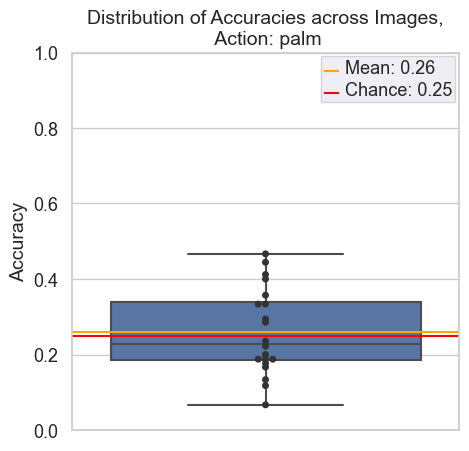

7


<ipython-input-28-291aeed06d50>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['%.01f' % y for y in ax.get_yticks()], size = 13)


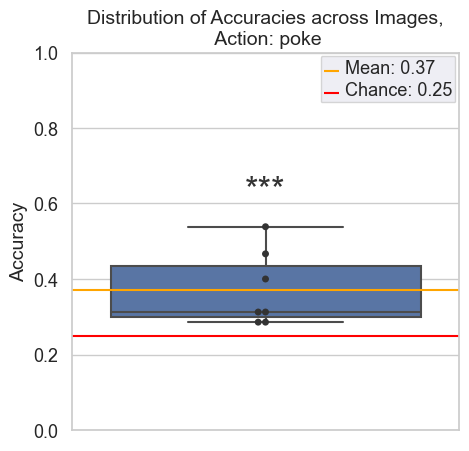

In [30]:
for action in ACTIONS:
    plot_box_swarm(acc_df.loc[acc_df['true_label'] == action][['y']],
                   'Distribution of Accuracies across Images,\n Action: %s' % action,
                   'mturk-classification-accuracies-box-swarm-plot-%s.png' % action)

In [31]:
import matplotlib.patches as mpatches

def plot_stacked_bars(y, title, name, x_tick_labels=None):
    # set the figure size
    plt.figure(figsize=(15, 15), dpi=200)
    bar1 = sns.barplot(data=(pd.DataFrame(y)+1-pd.DataFrame(y)).T, color='red')
    bar2 = sns.barplot(data=(pd.DataFrame(y)).T, color='green')

    # add legend
    top_bar = mpatches.Patch(color='red', label='nonmatch')
    bottom_bar = mpatches.Patch(color='green', label='match')
    plt.legend(handles=[top_bar, bottom_bar], fontsize=15)

    plt.ylim(0, 1)
    plt.xlim(0-.5, len(y)-.5)
    bar1.set_yticklabels(['%.01f' % y for y in bar1.get_yticks()], size = 13)
    bar1.set_xticklabels(bar1.get_xticks(), size = 10)
    if x_tick_labels is not None:
#         bar1.set_xticklabels([image_name[0].split('__')[0] for _, i in image_names.iterrows()],
#                              rotation=30, ha='right')
        bar1.set_xticklabels([label[0] for _, label in x_tick_labels.iterrows()])
    bar1.hlines(CHANCE_LEVEL, 0-.5, len(y)-.5, color='black')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Image', fontsize = 14)
    plt.title(title, fontsize = 15)

    # show the graph
    plt.savefig('%s/%s' % (output_dir, name))
    plt.show()

In [32]:
acc_df

,image_idx,true_label,image_name,y,n
0,0,pinch,31-aBsPwUYL._AC__pinch_combined.png,0.352941,17
1,1,pinch,31ACEy-64JL._AC__pinch_combined.png,0.428571,14
2,2,pinch,31CqNhSb4AL._AC__pinch_combined.png,0.500000,14
3,3,pinch,31k7mxeoKPL._AC__pinch_combined.png,0.473684,19
4,4,poke,413qDudtmYL._AC_SL1024__poke_combined.png,0.400000,15
...,...,...,...,...,...
60,63,palm,81ZUoSa1qbL._SL1500__palm_combined.png,0.066667,15
61,64,palm,81fKq7KP+SL._AC_SL1500__palm_combined.png,0.176471,17
62,65,palm,91EHb1zSIYL._AC_SL1500__palm_combined.png,0.333333,15
63,66,palm,91crUOSfR-L._SL1500__palm_combined.png,0.187500,16


<ipython-input-31-bb69c1d62fb2>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar1.set_yticklabels(['%.01f' % y for y in bar1.get_yticks()], size = 13)


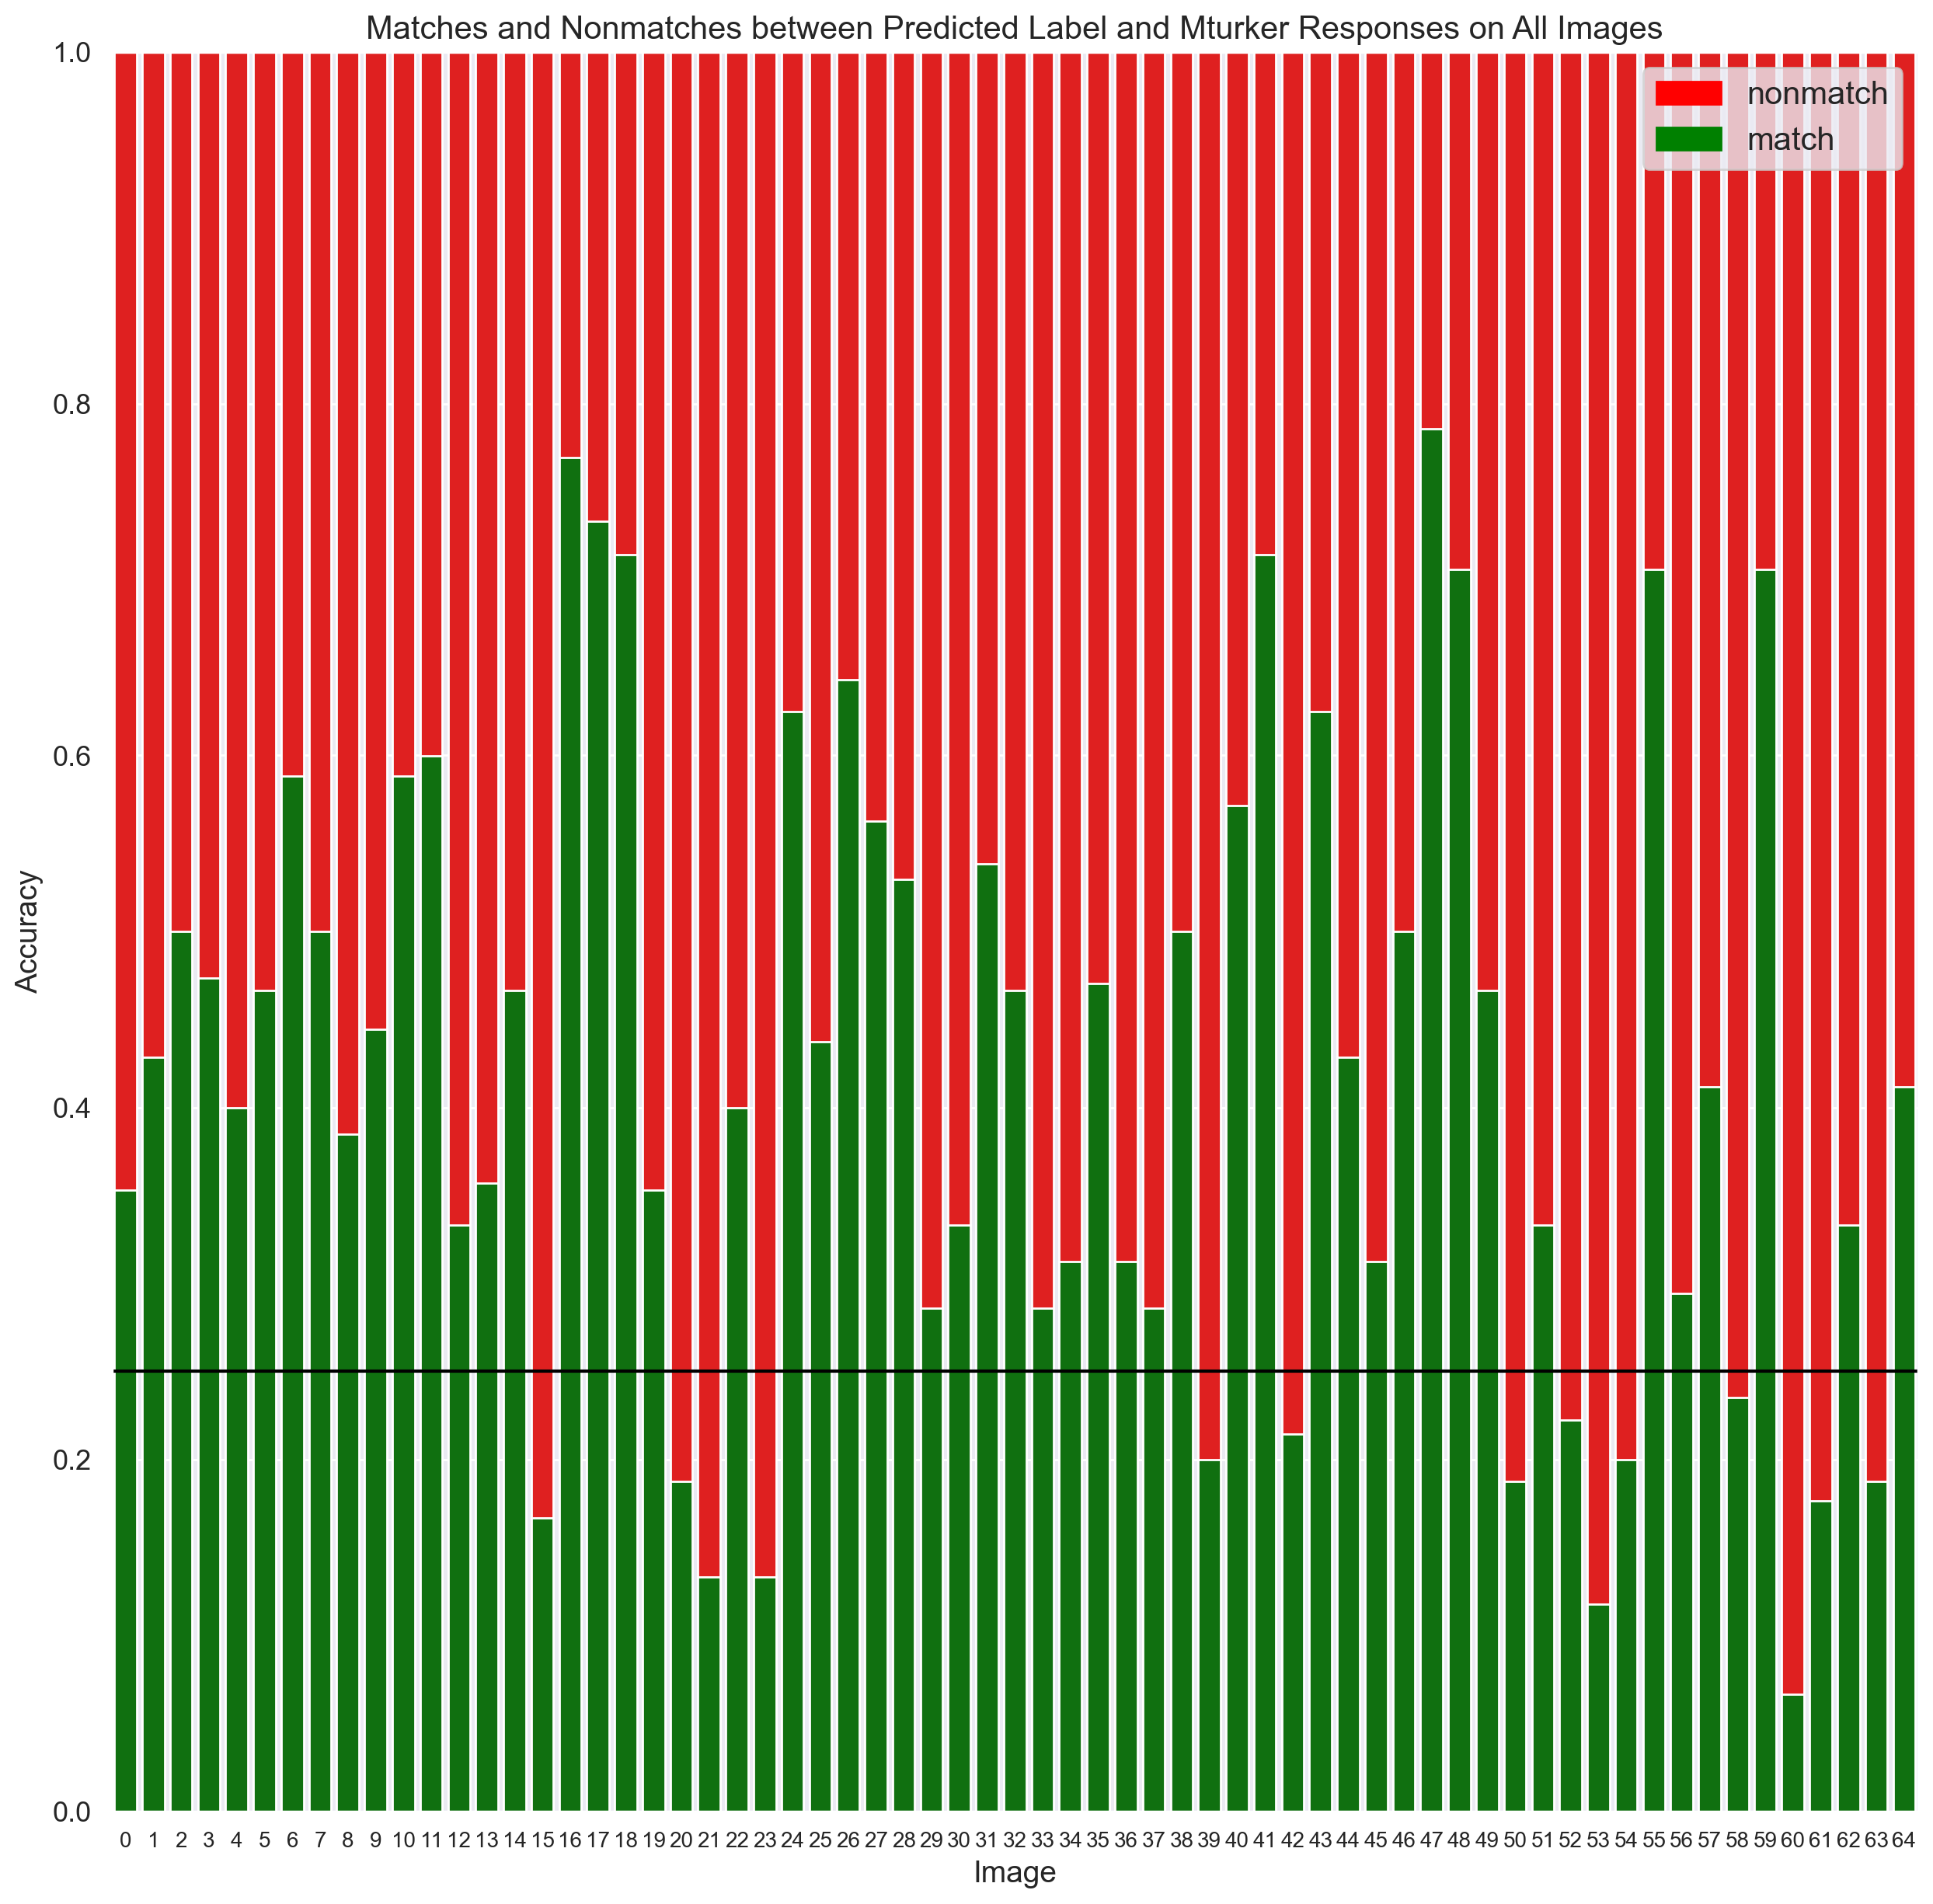

In [33]:
plot_stacked_bars(y, 'Matches and Nonmatches between Predicted Label and Mturker Responses on All Images', 
                  'mturk-classification-accuracies-stacked-bars-plot.png')

<ipython-input-31-bb69c1d62fb2>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar1.set_yticklabels(['%.01f' % y for y in bar1.get_yticks()], size = 13)


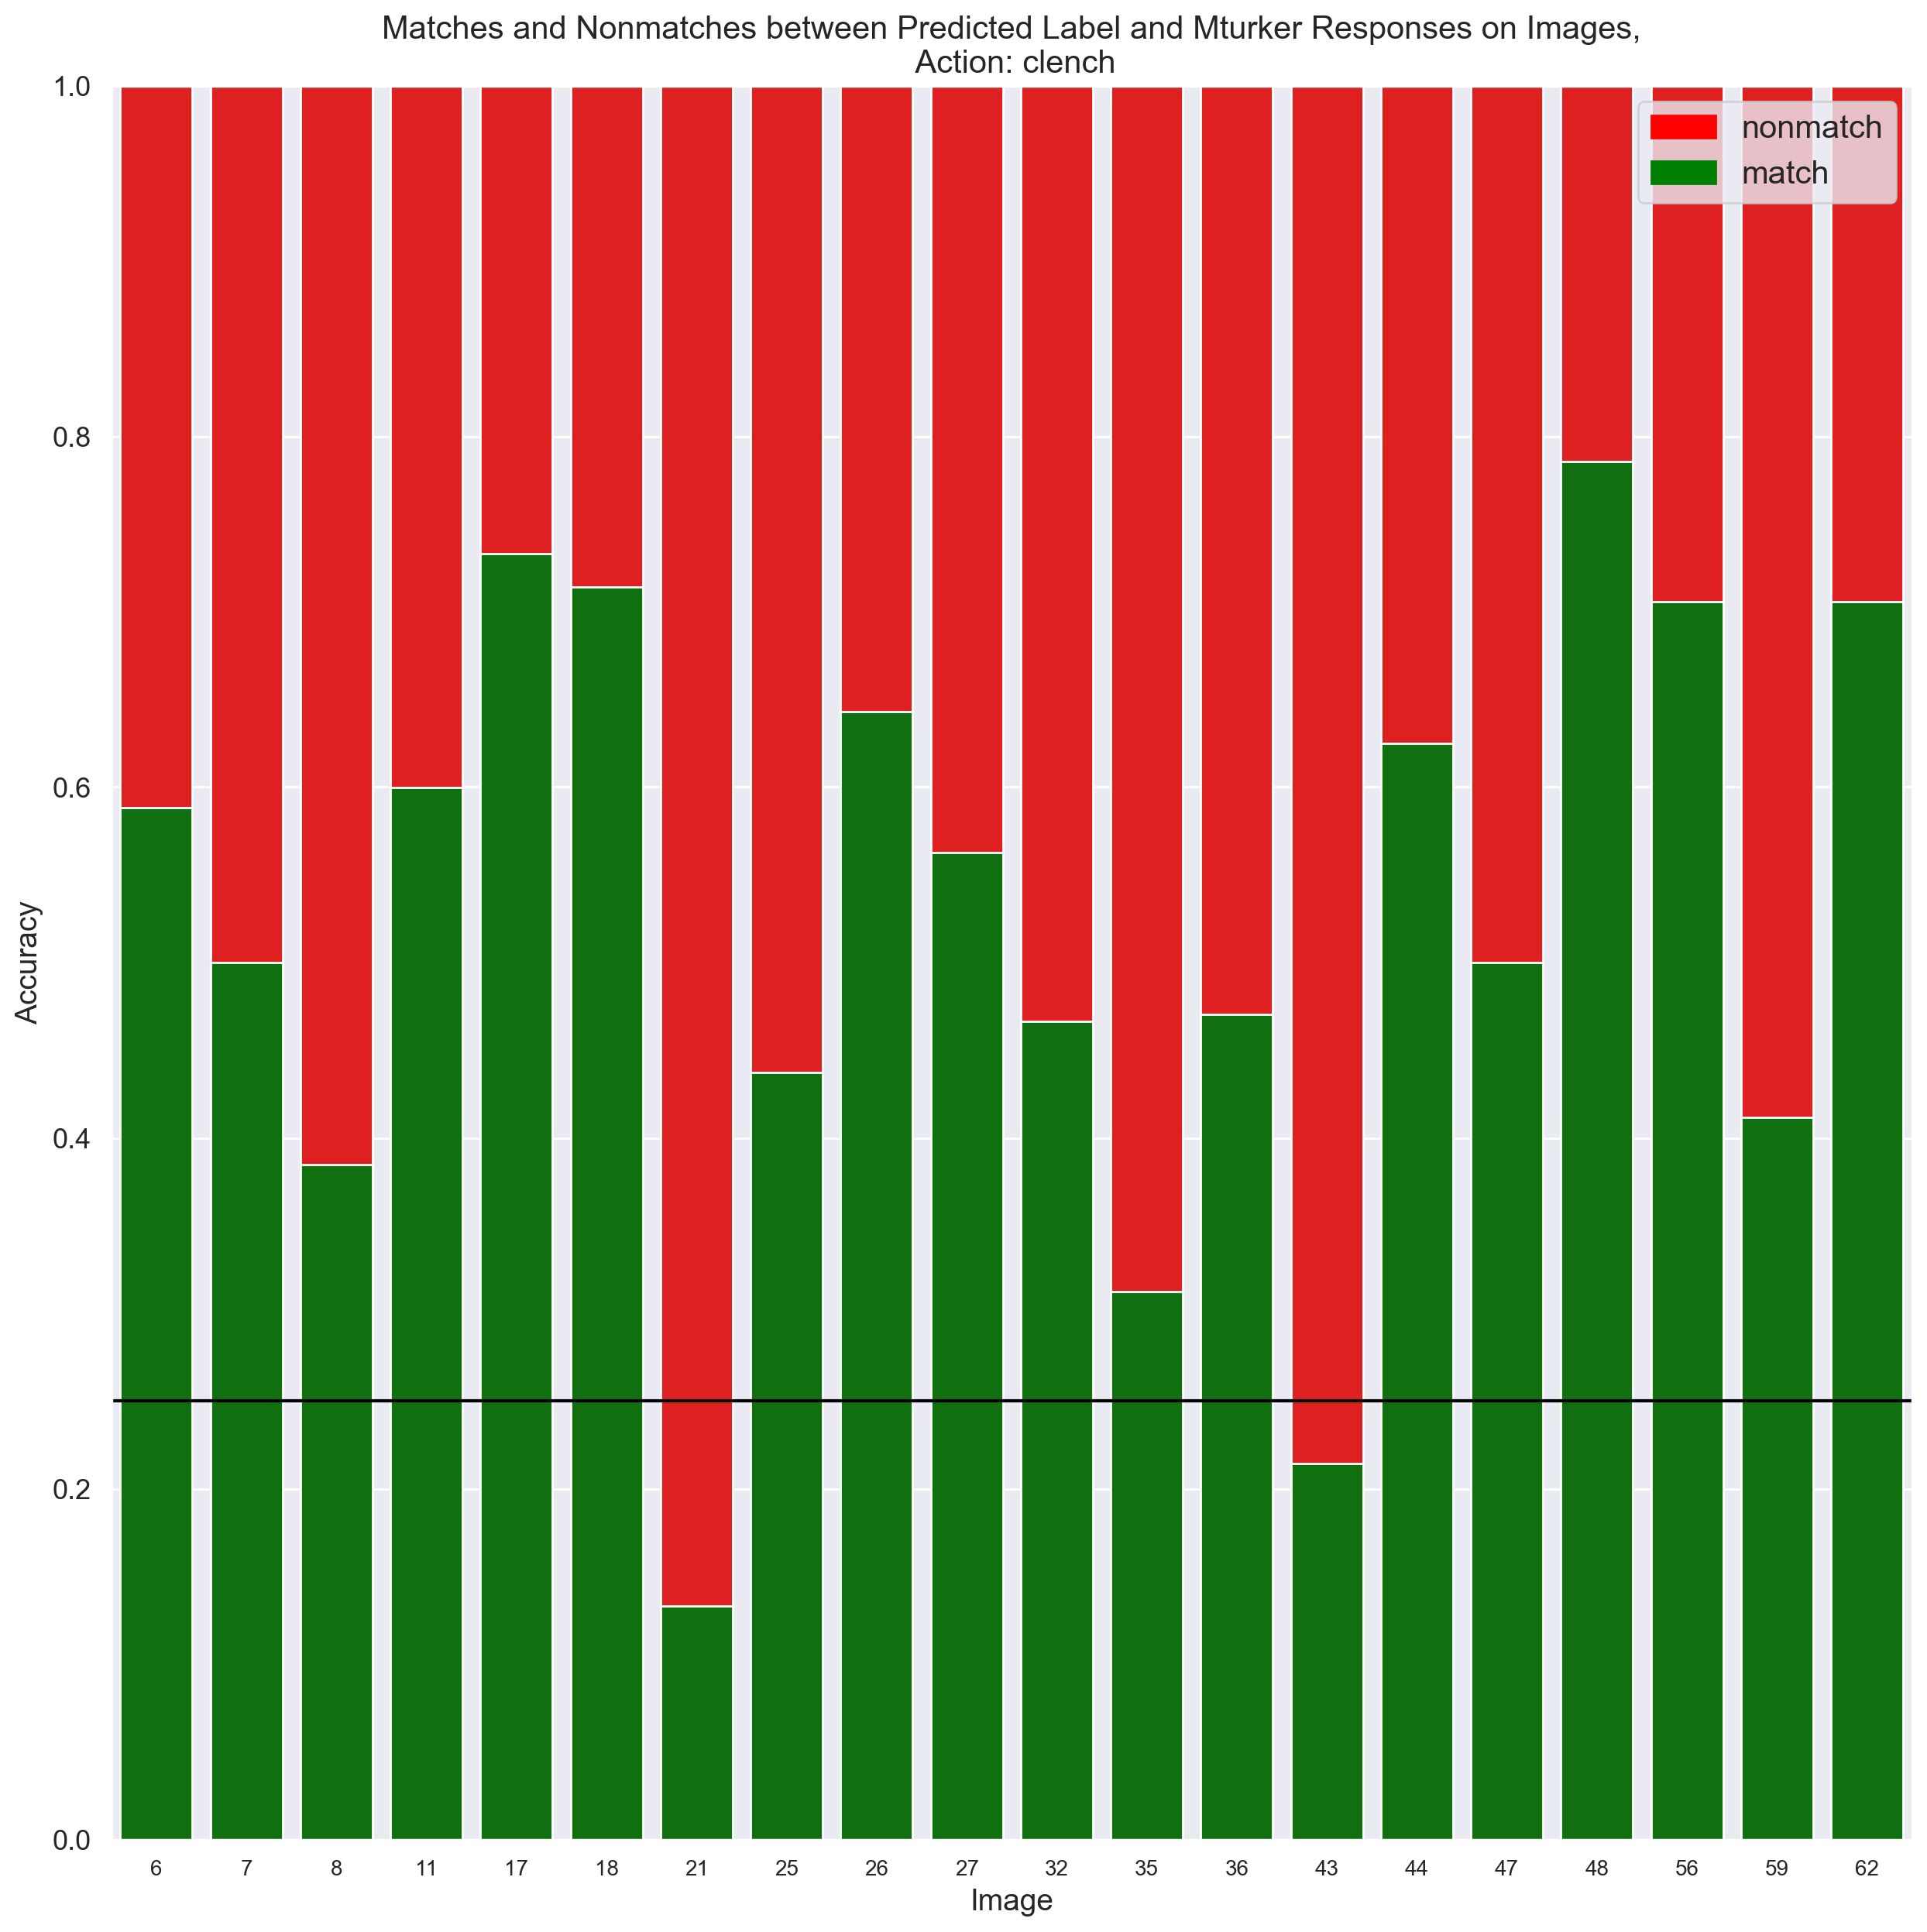

<ipython-input-31-bb69c1d62fb2>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar1.set_yticklabels(['%.01f' % y for y in bar1.get_yticks()], size = 13)


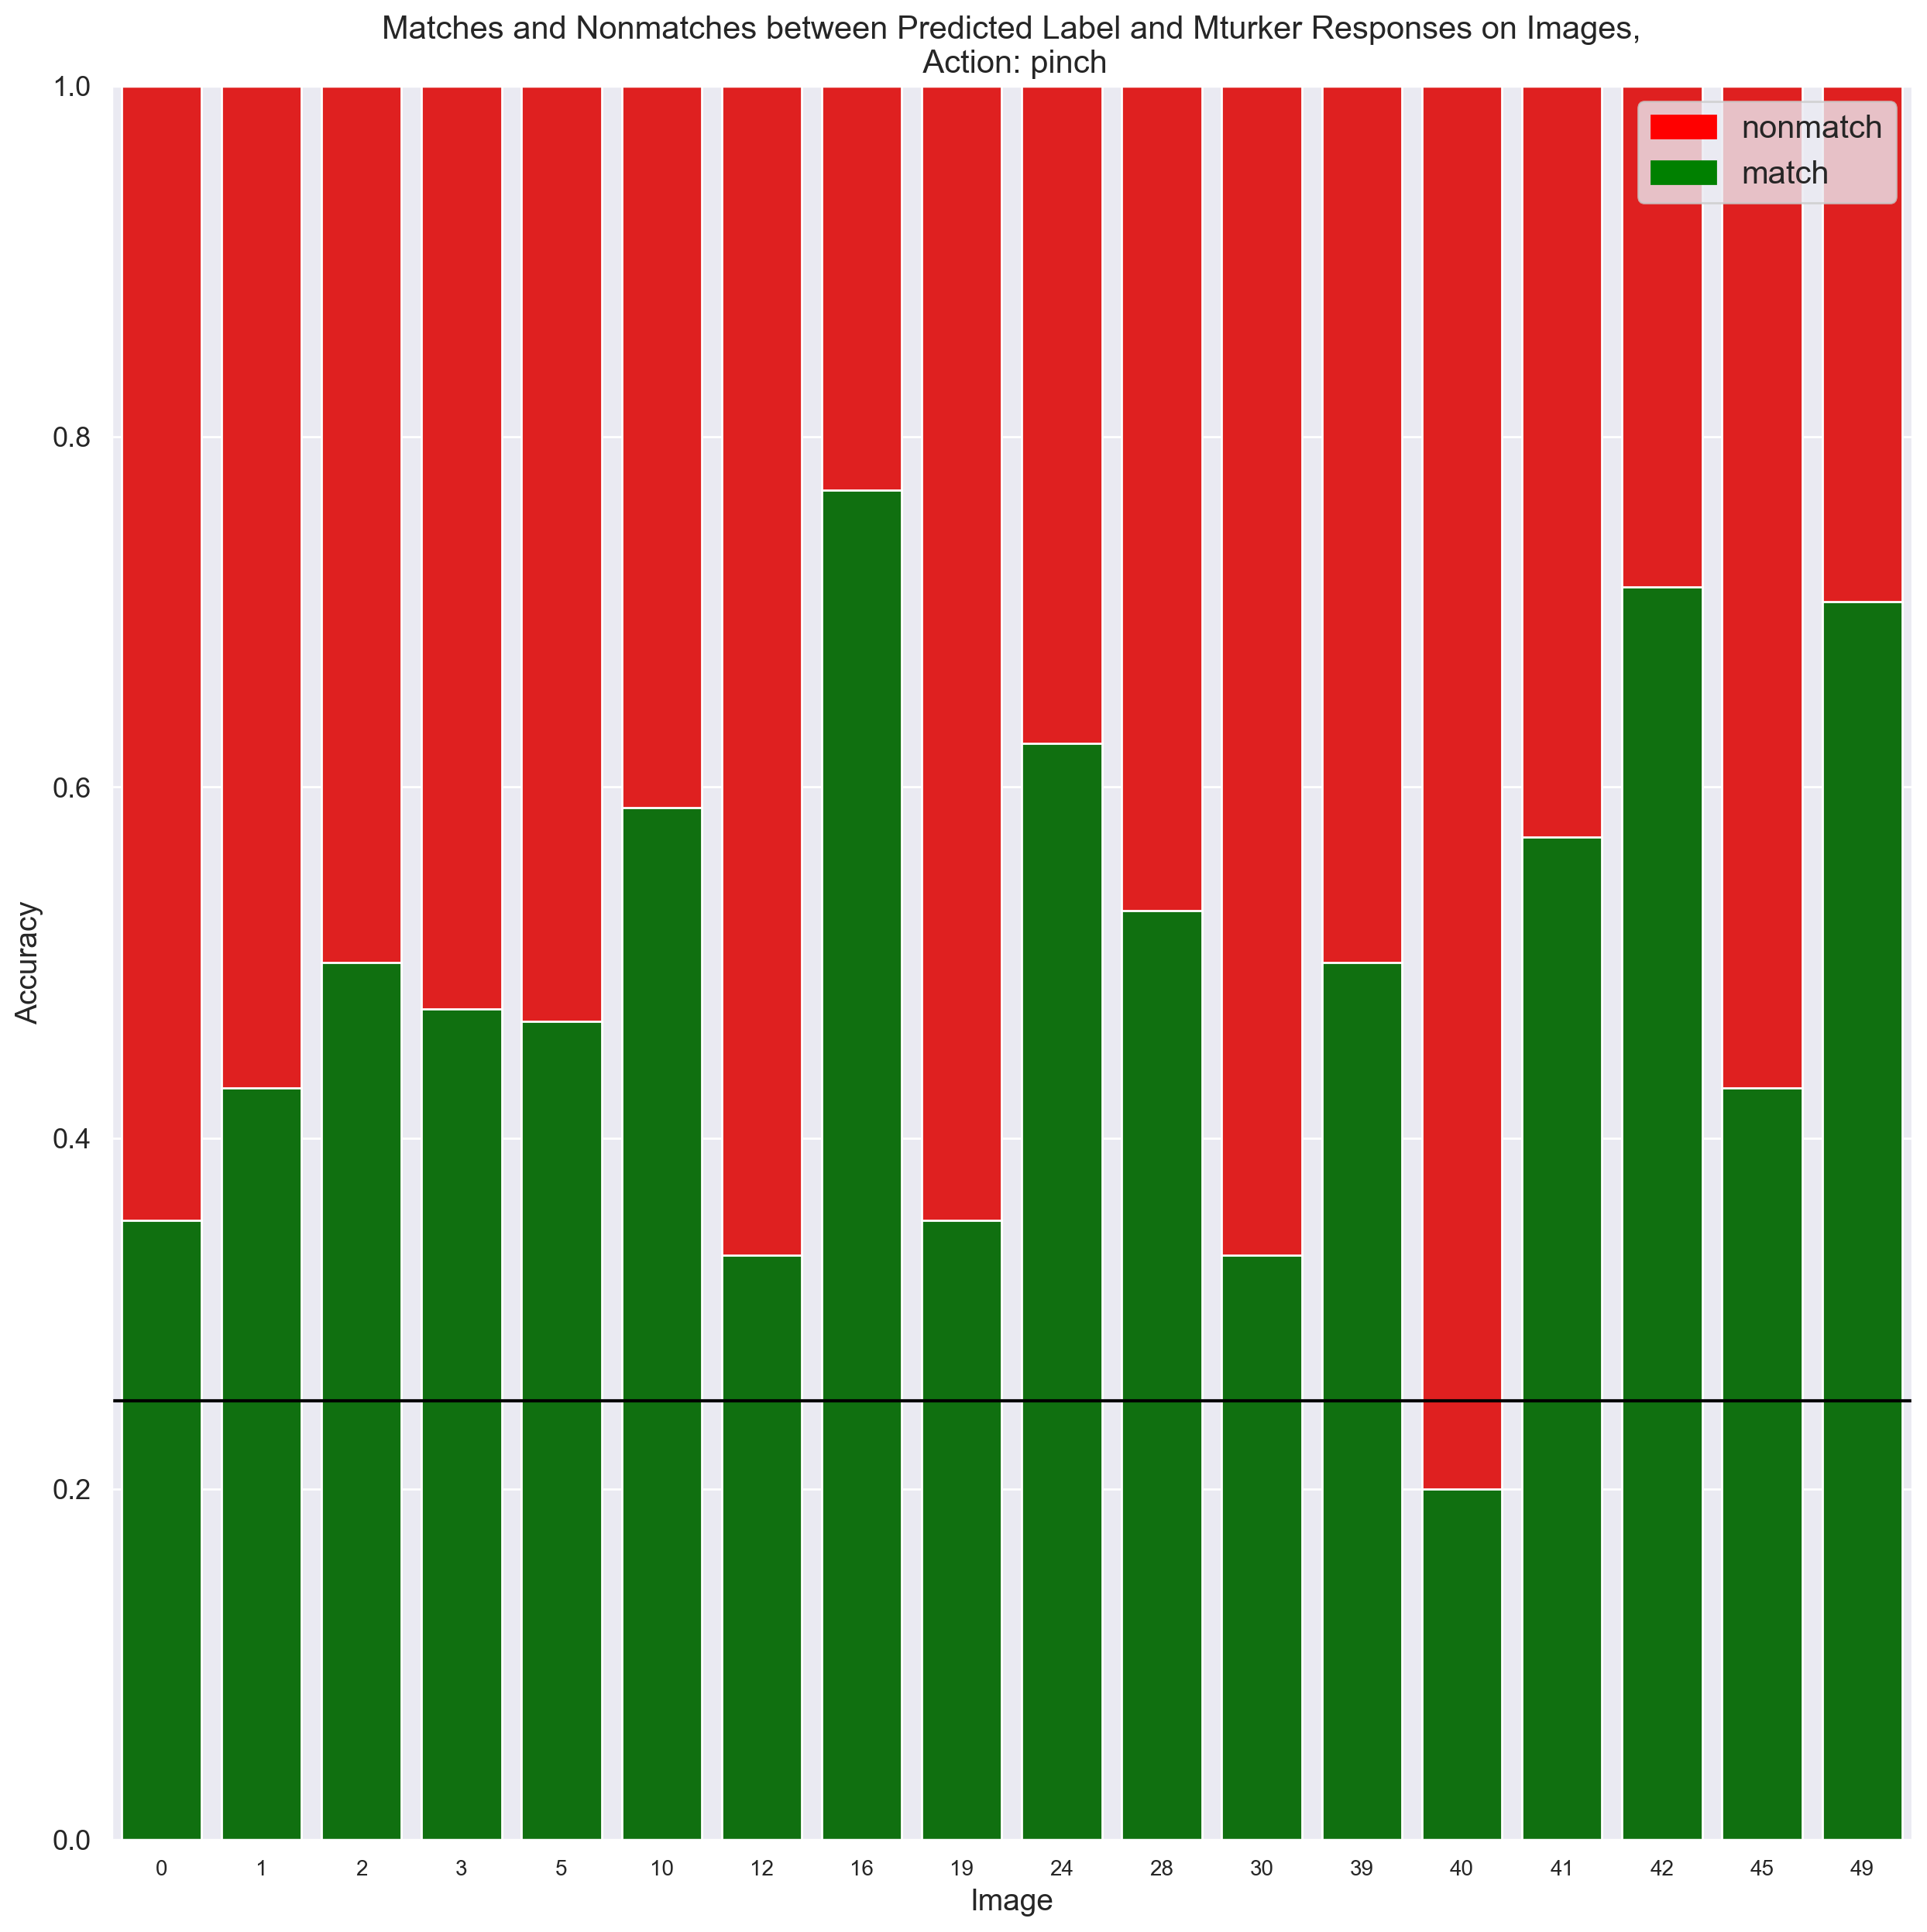

<ipython-input-31-bb69c1d62fb2>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar1.set_yticklabels(['%.01f' % y for y in bar1.get_yticks()], size = 13)


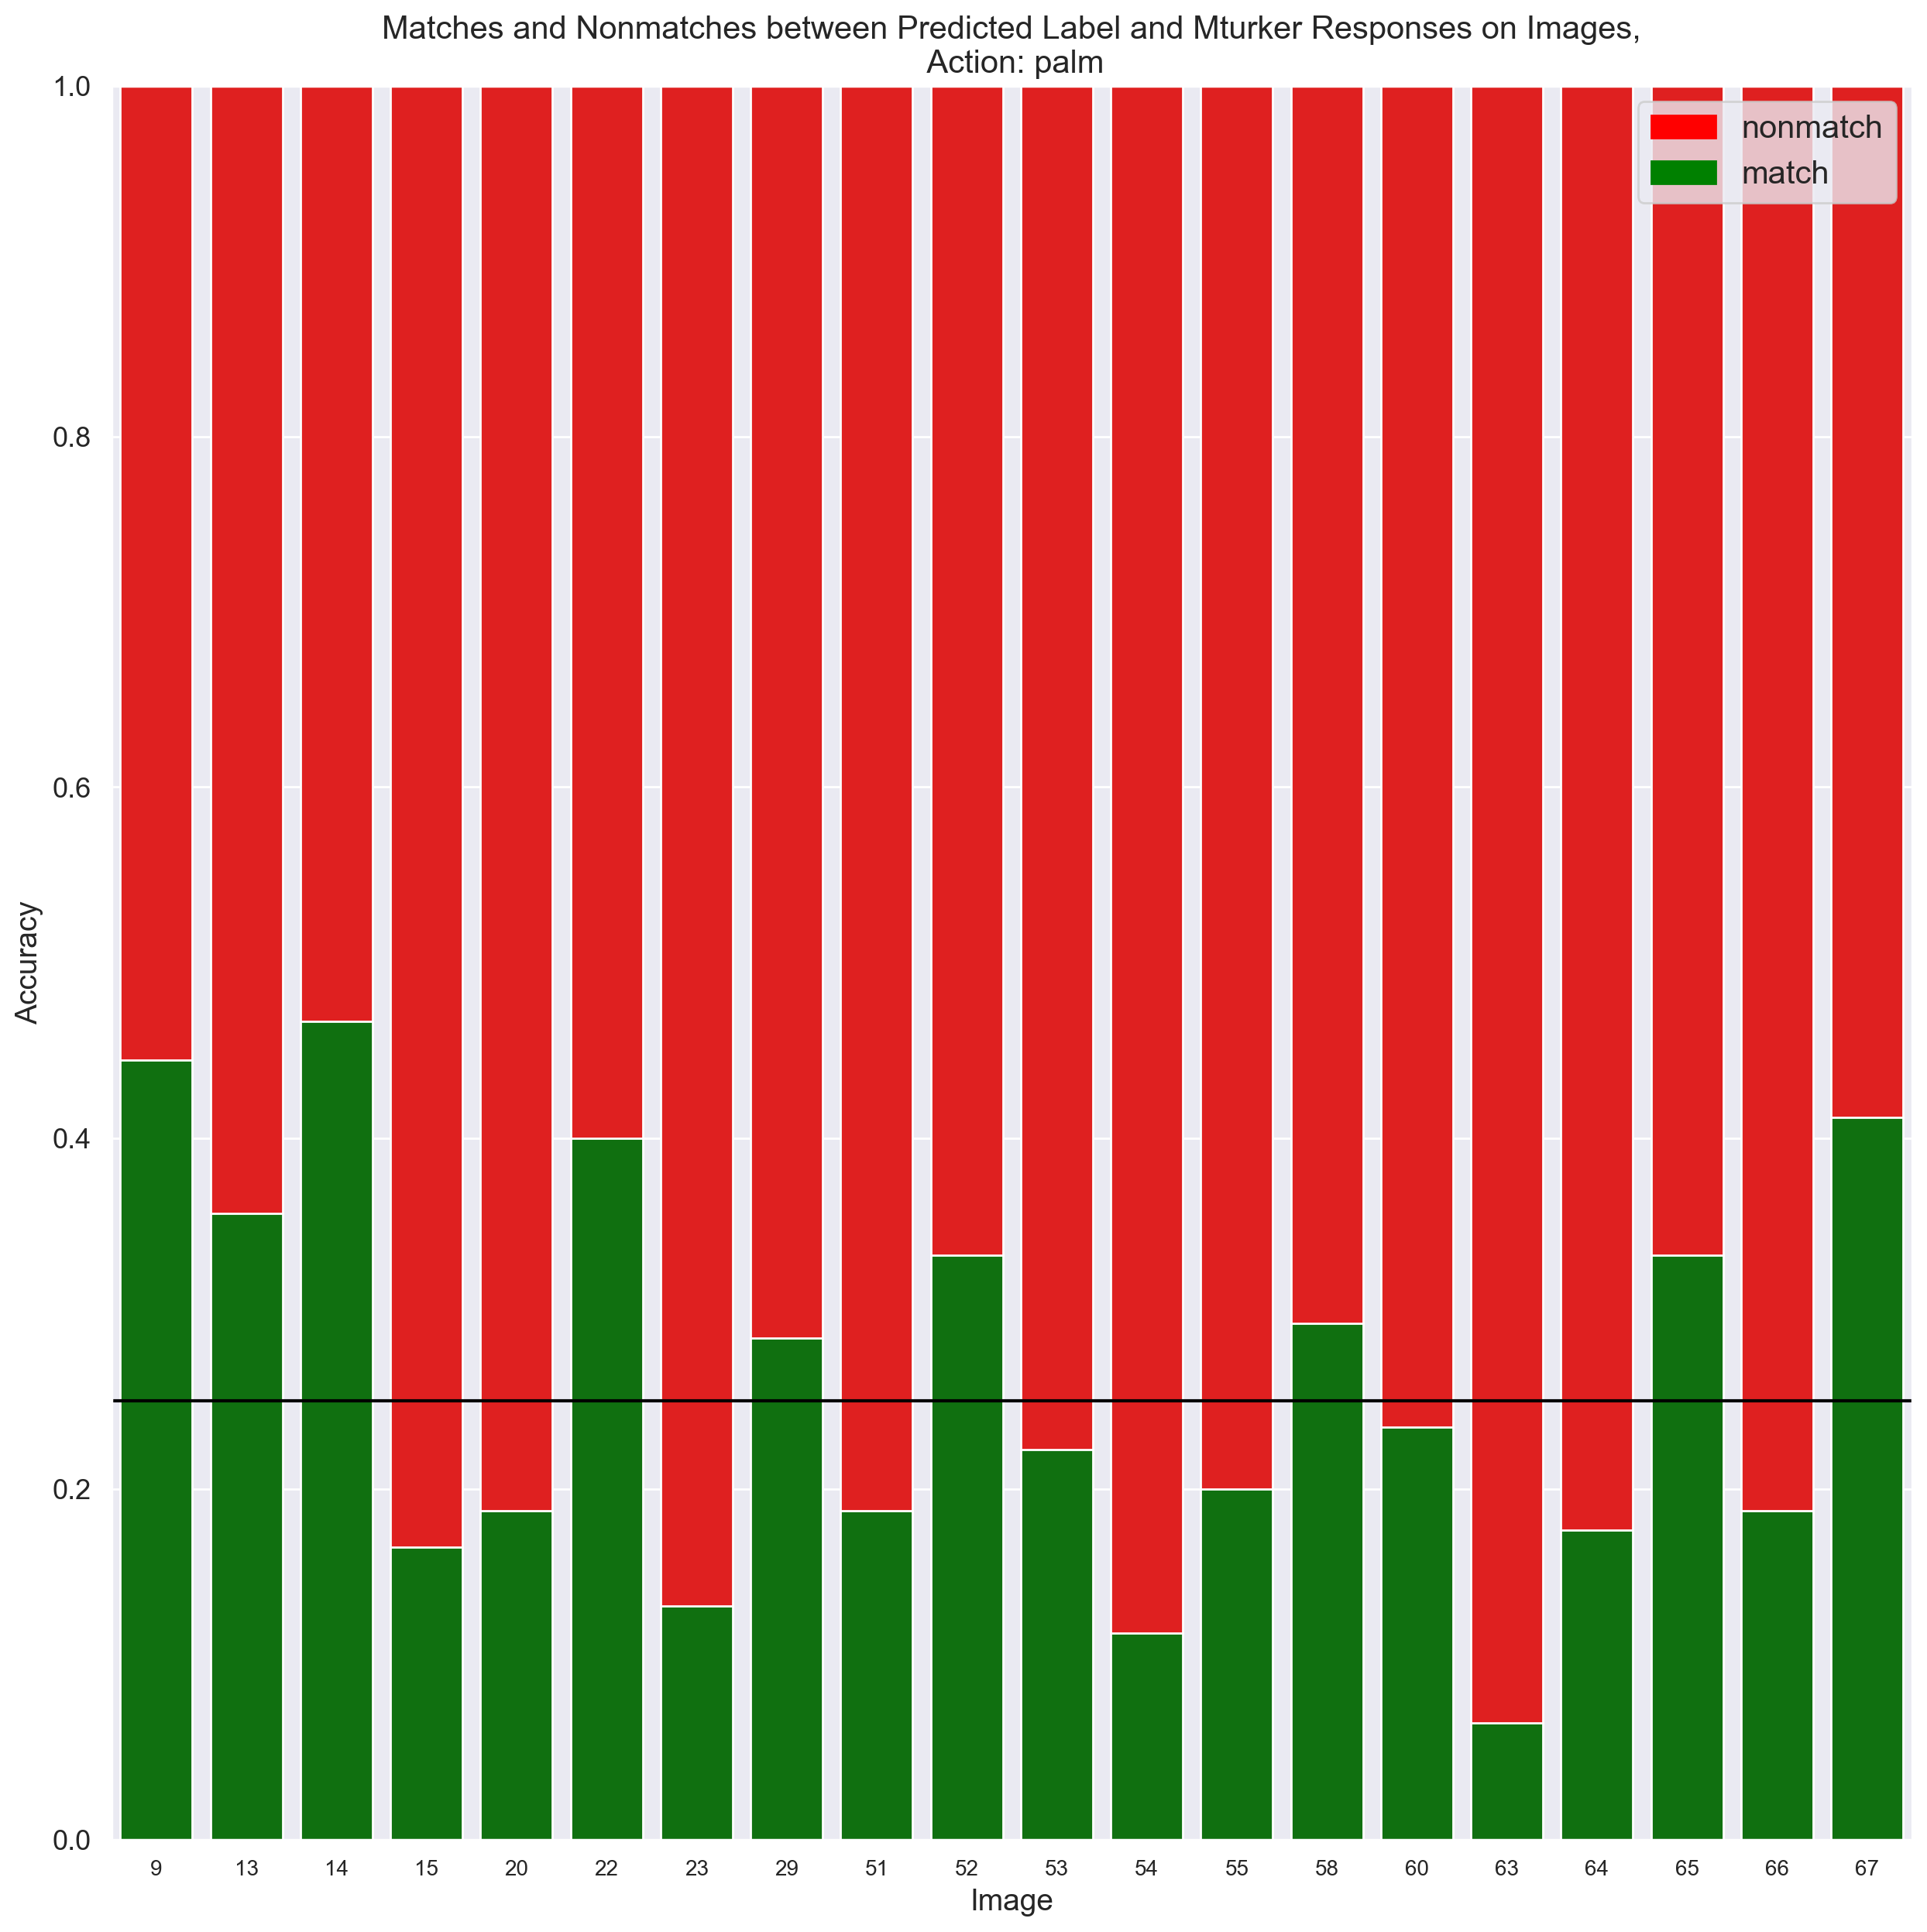

<ipython-input-31-bb69c1d62fb2>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar1.set_yticklabels(['%.01f' % y for y in bar1.get_yticks()], size = 13)


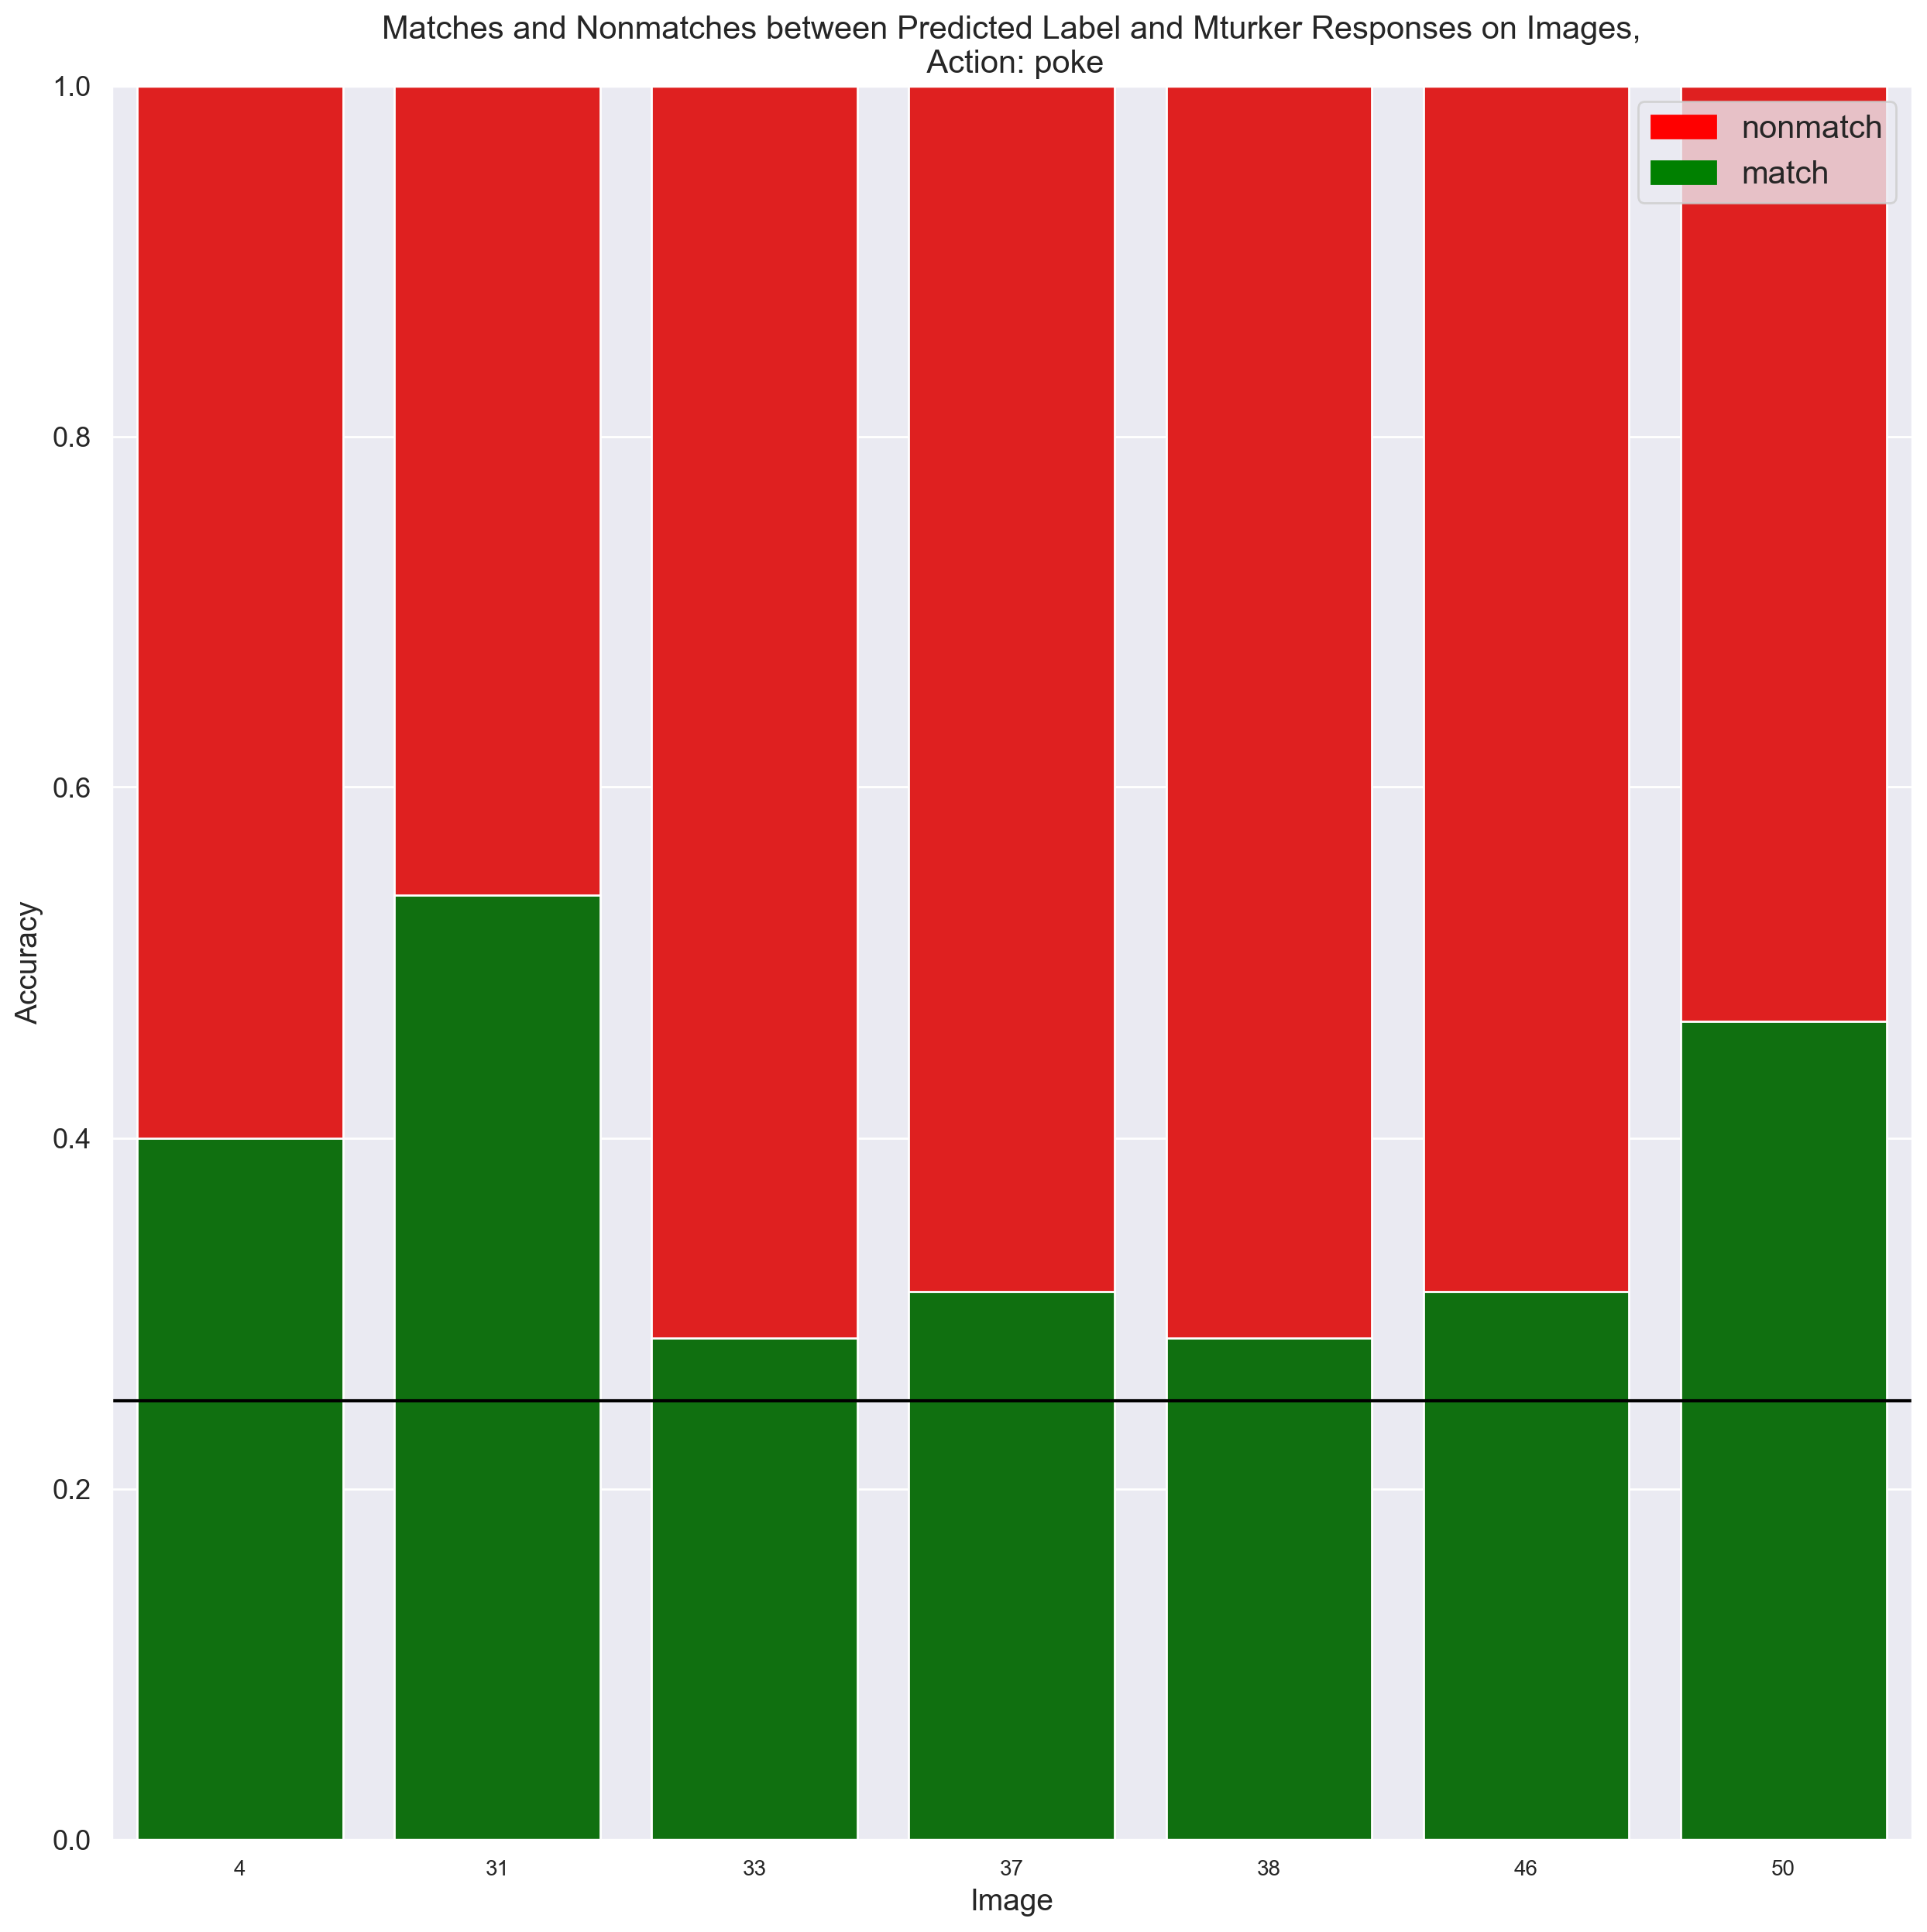

In [34]:
for action in ACTIONS:
    plot_stacked_bars(acc_df.loc[acc_df['true_label'] == action][['y']],
                      'Matches and Nonmatches between Predicted Label and Mturker Responses on Images,'\
                      '\n Action: %s' % action, 
                      'mturk-classification-accuracies-stacked-bars-plot-%s.png' % action,
                      x_tick_labels=acc_df.loc[acc_df['true_label'] == action][['image_idx']])

15 51Ozo7sPm+L._AC_SL1200__palm_combined.png 0.16666666666666666


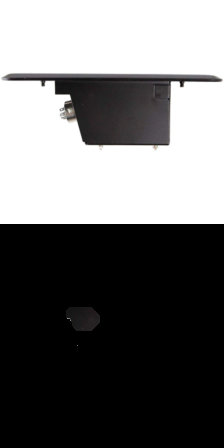

20 51do4Xi1bmL._AC_SL1500__palm_combined.png 0.1875


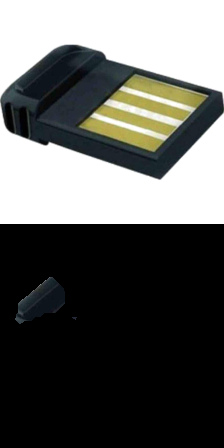

21 51iNJyvYH+L._AC_SL1000__clench_combined.png 0.13333333333333333


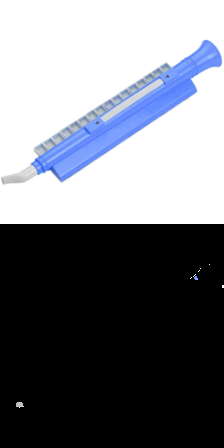

23 51qieN57cJL._AC_SL1001__palm_combined.png 0.13333333333333333


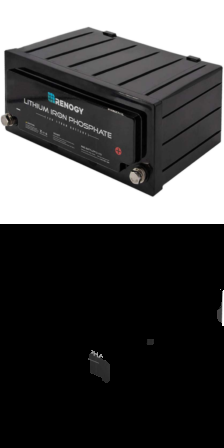

40 61sSZSFNNqL._AC_SL1200__pinch_combined.png 0.2


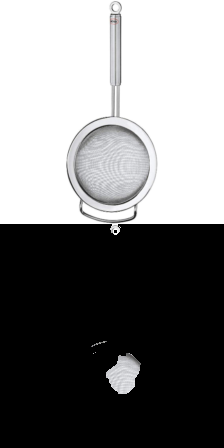

43 717r+SqXyLL._SL1392__clench_combined.png 0.21428571428571427


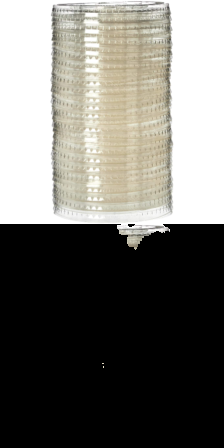

51 71dfTtaCz4L._AC_SL1500__palm_combined.png 0.1875


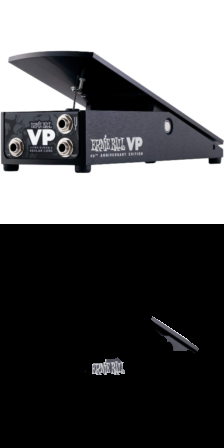

53 71jEz0ja-4L._AC_SL1500__palm_combined.png 0.2222222222222222


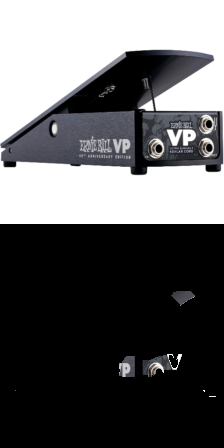

54 71oeelJslJL._AC_SL1200__palm_combined.png 0.11764705882352941


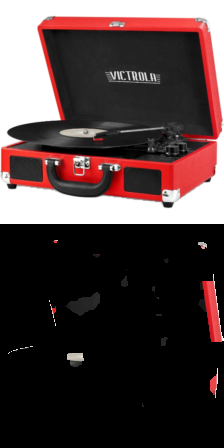

55 71qbjtKvOcL._AC_SL1500__palm_combined.png 0.2


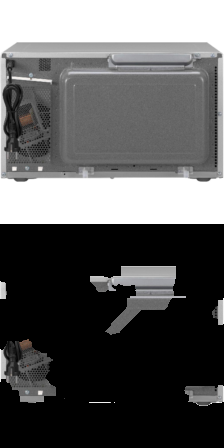

60 81MECm0ALyL._AC_SL1500__palm_combined.png 0.23529411764705882


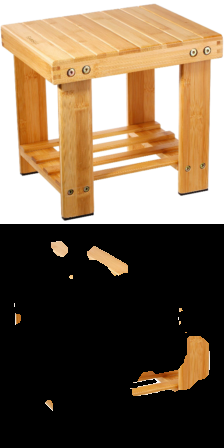

63 81ZUoSa1qbL._SL1500__palm_combined.png 0.06666666666666667


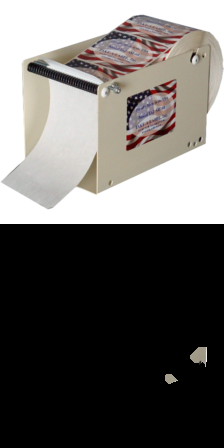

64 81fKq7KP+SL._AC_SL1500__palm_combined.png 0.17647058823529413


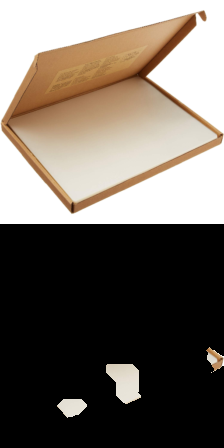

66 91crUOSfR-L._SL1500__palm_combined.png 0.1875


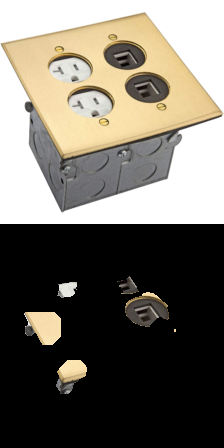

In [35]:
from IPython.display import Image, display

bad_df = acc_df.loc[acc_df['y'] < CHANCE_LEVEL]
for i, row in bad_df.iterrows():
    print(row['image_idx'], row['image_name'], row['y'])
    display(Image(filename='%s/%s' % (image_dir, row['image_name'])))

In [36]:
len(bad_df)

14

16 51PM8ETD7UL._AC_SL1000__pinch_combined.png 0.7692307692307693


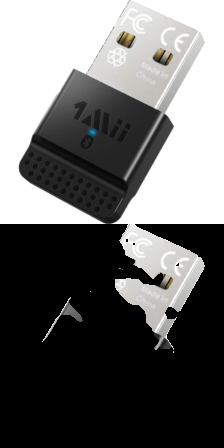

17 51Q0U6f4PnL._AC_SL1000__clench_combined.png 0.7333333333333333


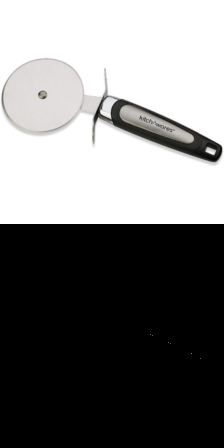

18 51QxFGFC8DL._AC_SL1000__clench_combined.png 0.7142857142857143


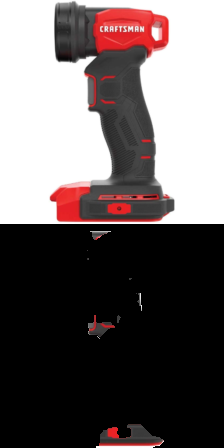

42 714iqgnEvmL._AC_SL1500__pinch_combined.png 0.7142857142857143


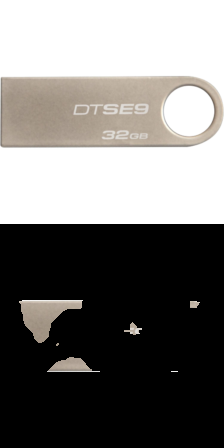

48 71LpYR3Z-5L._AC_SL1500__clench_combined.png 0.7857142857142857


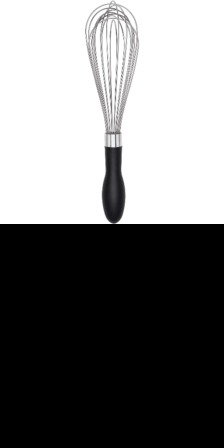

49 71MGpU93IqL._AC_SL1500__pinch_combined.png 0.7058823529411765


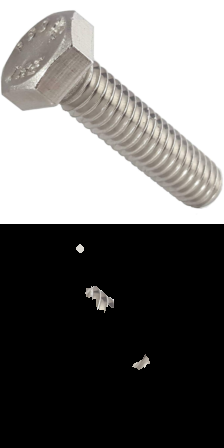

56 81173t977aL._AC_SL1500__clench_combined.png 0.7058823529411765


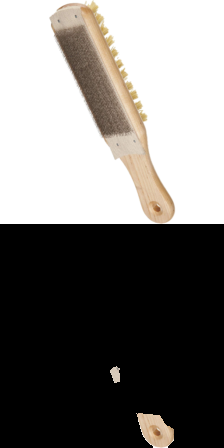

62 81VKHGsE4bL._AC_SL1500__clench_combined.png 0.7058823529411765


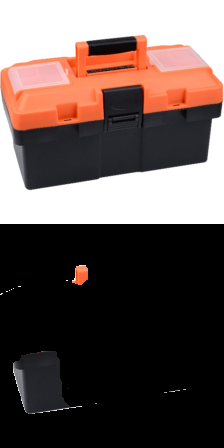

In [37]:
good_df = acc_df.loc[acc_df['y'] > .7]
for i, row in good_df.iterrows():
    print(row['image_idx'], row['image_name'], row['y'])
    display(Image(filename='%s/%s' % (image_dir, row['image_name'])))

In [38]:
len(good_df)

8

In [39]:
print(0.00890913618769872788 == 8.90913618769872788e-3)
print(0.00000060898622401828 == 6.0898622401828e-7)
print(.00000153283617967216 == 1.53283617967216e-6)
print(.34593939453143685014 == 3.4593939453143685014e-1)

True
True
True
True


In [40]:
0.00000000016716181277 == 1.6716181277e-10

True

In [41]:
acc_df

,image_idx,true_label,image_name,y,n
0,0,pinch,31-aBsPwUYL._AC__pinch_combined.png,0.352941,17
1,1,pinch,31ACEy-64JL._AC__pinch_combined.png,0.428571,14
2,2,pinch,31CqNhSb4AL._AC__pinch_combined.png,0.500000,14
3,3,pinch,31k7mxeoKPL._AC__pinch_combined.png,0.473684,19
4,4,poke,413qDudtmYL._AC_SL1024__poke_combined.png,0.400000,15
...,...,...,...,...,...
60,63,palm,81ZUoSa1qbL._SL1500__palm_combined.png,0.066667,15
61,64,palm,81fKq7KP+SL._AC_SL1500__palm_combined.png,0.176471,17
62,65,palm,91EHb1zSIYL._AC_SL1500__palm_combined.png,0.333333,15
63,66,palm,91crUOSfR-L._SL1500__palm_combined.png,0.187500,16


In [42]:
np.mean(acc_df[['n']])

n    15.230769
dtype: float64